In [ ]:
# import pandas subsitute - one or the other of these two
import modin.pandas as pd

In [1]:
# import libraries
import pandas as pd

In [2]:
# read csv
df_logons = pd.read_csv('logon.csv')

In [42]:
# check - first index
df_logons.iloc[0]

id             {S7X6-Z2CH44WU-9256VRTB}
date                2010-01-02 06:34:00
user                            EBH0519
pc                              PC-9573
activity                          Logon
dateHour                              6
dateDay                               2
calendarDay                  2010-01-02
dateString                     20100102
userDate               EBH0519_20100102
Name: 0, dtype: object

In [4]:
# number of user logins by pc
df_logons.groupby('pc')['user'].unique()

pc
PC-0015    [TKW0289, WSP0210, JVS0212, DWG0209, BLA0039, ...
PC-0027    [HDE0756, BLA0039, DWG0209, LEB0888, LUP0038, ...
PC-0042    [AMR0208, JVS0212, PAW0040, WSP0210, LUP0038, ...
PC-0051    [LXW0999, HKW0211, DWG0209, UAP0214, ZNS0213, ...
PC-0059    [GRM0263, WSP0210, UAP0214, ZNS0213, BLA0039, ...
                                 ...                        
PC-9961    [HRL0797, ZNS0213, LUP0038, DWG0209, JVS0212, ...
PC-9974    [WMH0866, BJE0520, UAP0214, DWG0209, HKW0211, ...
PC-9979                 [DZJ0261, PAW0040, BLA0039, JVS0212]
PC-9989    [LDF0262, DWG0209, HKW0211, LUP0038, UAP0214, ...
PC-9999    [JAW0007, DWG0209, WSP0210, PAW0040, CZB0191, ...
Name: user, Length: 953, dtype: object

In [5]:
# looking specifically at one, we see that one user principle uses this machine
df_logons[df_logons['pc'] == 'PC-0015']['user'].value_counts()

TKW0289    1198
JVS0212      10
DWG0209       4
ZNS0213       4
WSP0210       2
BLA0039       2
LUP0038       2
HKW0211       2
BJH0243       2
Name: user, dtype: int64

In [1]:
# the number of pcs in the environment
len(df_logons)

NameError: name 'df_logons' is not defined

In [7]:
# types of activities
df_logons['activity'].unique()

array(['Logon', 'Logoff'], dtype=object)

In [8]:
# convert date to datetime
df_logons['date']  = pd.to_datetime(df_logons['date'])

In [9]:
# pull hour from datetime
df_logons['dateHour'] = df_logons['date'].dt.hour

In [10]:
# pull day from datetime
df_logons['dateDay'] = df_logons['date'].dt.day

In [11]:
# activities in total for all users all time.
df_logons.groupby('user').count()

,id,date,pc,activity,dateHour,dateDay
user,,,,,,
AAC0070,690,690,690,690,690,690
AAP0946,1185,1185,1185,1185,1185,1185
AAR0716,993,993,993,993,993,993
AAS0850,963,963,963,963,963,963
ABG0865,1680,1680,1680,1680,1680,1680
...,...,...,...,...,...,...
ZKC0722,690,690,690,690,690,690
ZLB0620,690,690,690,690,690,690
ZLW0169,690,690,690,690,690,690


In [12]:
# pull calendar date from datetime
df_logons['calendarDay'] = df_logons['date'].dt.date

In [13]:
# last date seen for user
df_logons[df_logons['user'] == 'ABM0173']['calendarDay'].max()

datetime.date(2011, 1, 21)

In [14]:
# compile hasLogin dateframe
# group by user calendar day when activity is logon. count and pull one column. reset the index
df_hasLogon = df_logons[df_logons['activity'] == 'Logon'].groupby(['user', 'calendarDay']).count()['date'].reset_index()
# create a string that represents the date and add as column
df_hasLogon['dateString'] = df_hasLogon['calendarDay'].apply(lambda x: x.strftime('%Y%m%d'))
# create the userDate field by concat user_dateString
df_hasLogon['userDate'] = df_hasLogon.apply(lambda x: x['user'] + '_' + x['dateString'], axis=1)
# drop all the columns except for the two needed
df_hasLogon = df_hasLogon[['userDate','date']]
# display dataframe
df_hasLogon

,userDate,date
0,AAC0070_20100104,1
1,AAC0070_20100105,1
2,AAC0070_20100106,1
3,AAC0070_20100107,1
4,AAC0070_20100108,1
...,...,...
339993,ZSP0972_20110509,1
339994,ZSP0972_20110510,1
339995,ZSP0972_20110511,1
339996,ZSP0972_20110512,1


In [15]:
# rename the columns and save to a pickle file in the directory
df_hasLogon.rename(columns={'date':'count'}).to_pickle('hasLogins.pkl')

In [16]:
# create datestring in main dataframe
df_logons['dateString'] = df_logons['calendarDay'].apply(lambda x: x.strftime('%Y%m%d'))
# create userDate in main dataframe
df_logons['userDate'] = df_logons.apply(lambda x: x['user'] + '_' + x['dateString'], axis=1)
# find the number of distinct pc where a logon event occured by userDate. rename the columns
df_numPC = df_logons[df_logons['activity'] == 'Logon'].groupby('userDate')['pc'].nunique().to_frame().rename(columns={'pc':'countPC'})
# display when not 1
df_numPC[df_numPC['countPC'] != 1]
# save to a pickle file
df_numPC.to_pickle('numPC.pkl')

In [17]:
# import KDE
from sklearn.neighbors import KernelDensity

In [18]:
# count the columns by dateHour - only 24; 0-23
df_logons.groupby('dateHour').count()

,id,date,user,pc,activity,dateDay,calendarDay,dateString,userDate
dateHour,,,,,,,,,
0,2369,2369,2369,2369,2369,2369,2369,2369,2369
1,2489,2489,2489,2489,2489,2489,2489,2489,2489
2,2629,2629,2629,2629,2629,2629,2629,2629,2629
3,2667,2667,2667,2667,2667,2667,2667,2667,2667
4,2709,2709,2709,2709,2709,2709,2709,2709,2709
5,2919,2919,2919,2919,2919,2919,2919,2919,2919
6,19706,19706,19706,19706,19706,19706,19706,19706,19706
7,175917,175917,175917,175917,175917,175917,175917,175917,175917
8,124665,124665,124665,124665,124665,124665,124665,124665,124665


In [19]:
# check one index location
df_logons[df_logons['activity'] == 'Logon'].groupby('user')['dateHour'].value_counts().loc['AAC0070']

dateHour
7    345
Name: dateHour, dtype: int64

In [20]:
# new dataframe with Logon by user date
df_numLogonDate = df_logons[df_logons['activity'] == 'Logon'].groupby(['user','date']).count()

In [21]:
# check when logindate seem to be high
df_numLogonDate[df_numLogonDate['id'] > 1 ]

,,id,pc,activity,dateHour,dateDay,calendarDay,dateString,userDate
user,date,,,,,,,,
BLA0039,2011-03-31 22:39:33,2,2,2,2,2,2,2,2
JVS0212,2010-10-27 20:42:34,2,2,2,2,2,2,2,2


In [22]:
# read ldap pick from ldap
df_ldap = pd.read_pickle('../ldap/ldap.pkl')

In [23]:
# create dataframe with distinct user_id and role, rename for merge
df_userRole = df_ldap[['user_id', 'role']].drop_duplicates()
df_userRole.rename(columns={'user_id':'user'}, inplace=True)

In [24]:
# merge on user to logons so logons + userRole = logonsRole
df_logonsRole = df_logons.merge(df_userRole, on='user')

In [25]:
# check - dislay logon hour by role 
df_logonsRole.groupby('role').value_counts(['dateHour'])

role           dateHour
Accountant     7           1079
               15          1058
               18           798
               9            749
               8            660
                           ... 
VicePresident  18           180
               11           178
               14           133
               10            72
               17            16
Length: 760, dtype: int64

<Axes: title={'center': 'Accountant activity'}, xlabel='hour', ylabel='count'>

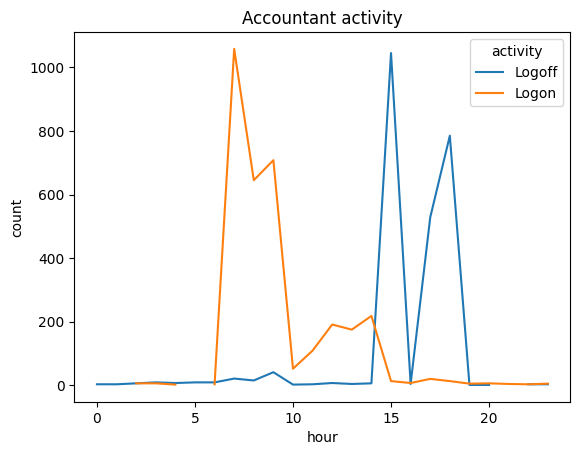

In [41]:
# generate visual showing logins and logouts for account
#df_logonsRole.groupby('role').value_counts(['dateHour']).loc['Accountant'].sort_index().plot()
df_logonsRole.groupby(['role','activity']).value_counts(['dateHour']).loc['Accountant'].to_frame().reset_index()\
    .pivot(index='dateHour', columns='activity', values=0).plot(xlabel='hour', ylabel='count', title='Accountant activity')

In [ ]:
# test - generate dataframe for accountants logon
df_LoginAccountant = df_logonsRole[(df_logonsRole['role'] == 'Accountant') &
                                    (df_logonsRole['activity'] == 'Logon')]

In [ ]:
# test - find all dateHours for this new accountant dataframe
df_LoginAccountant['dateHour'].array

In [ ]:
# test - generate a kde for accountant by dateHour array using reshape to collect results
#kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(df_LoginAccountant['dateHour'][:, np.newaxis])
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(df_LoginAccountant['dateHour'].array.reshape(-1, 1))

In [ ]:
# test - all probabilities for all hours for accountant sum to 1 = true
import numpy as np

temp = []

for hour in range(0,24):
    density = np.exp(kde.score_samples([[hour]]))
    temp.append(density[0])

sum(temp)

In [ ]:
# code block to define a dictionary for all the role and the probabilies associated with each logon hour
# prints probabily check for each role
roleProbHour = {}


for role in df_logonsRole['role'].unique():
    
    df_LoginHour = df_logonsRole[(df_logonsRole['role'] == role) &
                                    (df_logonsRole['activity'] == 'Logon')]
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(df_LoginHour['dateHour'].array.reshape(-1, 1))
    temp = {}

    for hour in range(0,24):
        density = np.exp(kde.score_samples([[hour]]))
        temp[hour] = density[0]

    roleProbHour[role] = temp

    print(role, sum(temp.values()))
    

In [ ]:
# generate a dataframe from the dictionary. transposes the dataframe with it all 
df_roleProbHour = pd.DataFrame(roleProbHour).transpose()
#df_roleProbHour.head()
#df_roleProbHour.loc['Scientist', 4]

# store it into a pickle
df_roleProbHour.to_pickle('roleProbHour.pkl')

In [ ]:
# do the same thing for roles and logout/logoff
roleProbLogoutHour = {}


for role in df_logonsRole['role'].unique():
    
    df_LoginHour = df_logonsRole[(df_logonsRole['role'] == role) &
                                    (df_logonsRole['activity'] == 'Logoff')]
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(df_LoginHour['dateHour'].array.reshape(-1, 1))
    temp = {}

    for hour in range(0,24):
        density = np.exp(kde.score_samples([[hour]]))
        temp[hour] = density[0]

    roleProbLogoutHour[role] = temp

    print(role, sum(temp.values()))

In [ ]:
# generate dataframe and save to pickle
df_roleProbLogoutHour = pd.DataFrame(roleProbLogoutHour).transpose()
#df_roleProbHour.head()
#df_roleProbHour.loc['Scientist', 4]
df_roleProbLogoutHour.to_pickle('roleProbLogoutHour.pkl')

In [ ]:
# generate a copy of logons to find all the logons for each user - multiple rows per userDate
df_logonHour = df_logons.copy()
df_logonHour['dateString'] = df_logonHour['calendarDay'].apply(lambda x: x.strftime('%Y%m%d'))
df_logonHour['userDate'] = df_logonHour.apply(lambda x: x['user'] + '_' + x['dateString'], axis=1)
df_logonHour = df_logonHour[df_logonHour['activity'] == 'Logon']
df_logonHour = df_logonHour[['userDate','dateHour']]
# comment if not to over write
#df_logonHour.to_pickle('logonHour.pkl')

In [ ]:
# generate a copy of logons to find all the logoffs for each user - multiple rows per userDate
df_logoutHour = df_logons.copy()
df_logoutHour['dateString'] = df_logoutHour['calendarDay'].apply(lambda x: x.strftime('%Y%m%d'))
df_logoutHour['userDate'] = df_logoutHour.apply(lambda x: x['user'] + '_' + x['dateString'], axis=1)
df_logoutHour = df_logoutHour[df_logoutHour['activity'] == 'Logoff']
df_logoutHour = df_logoutHour[['userDate','dateHour']]
df_logoutHour.to_pickle('logoutHour.pkl')


In [ ]:
# check - old test file. open with excel to find all logons for user 
df_logons[(df_logons['activity'] == 'Logon') & (df_logons['user'] == 'AJM0772')].to_csv('test.csv')

In [ ]:
# code block to define a dictionary for each user and the probabilies associated with each logon hour

userProbHour = {}

for user in df_logons['user'].unique():
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(df_logons[ (df_logons['user'] == user) & (df_logons['activity'] == 'Logon') ].groupby('userDate')['dateHour'].min().values.reshape(-1,1))
    temp = {}

    for hour in range(0,24):
        density = np.exp(kde.score_samples([[hour]]))
        temp[hour] = density[0]

    userProbHour[user] = temp
    
    #print(user, sum(temp.values()))

In [ ]:
# generate dataframe and save to pickle
df_userProbHour = pd.DataFrame(userProbHour).transpose()
#df_roleProbHour.head()
#df_roleProbHour.loc['Scientist', 4]
df_userProbHour.to_pickle('userProbHour.pkl')

In [ ]:
# code block to define a dictionary for each user and the probabilies associated with each logoff hour
userProbLogoutHour = {}

for user in df_logons['user'].unique():
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(df_logons[ (df_logons['user'] == user) & (df_logons['activity'] == 'Logoff') ].groupby('userDate')['dateHour'].max().values.reshape(-1,1))
    temp = {}

    for hour in range(0,24):
        density = np.exp(kde.score_samples([[hour]]))
        temp[hour] = density[0]

    userProbLogoutHour[user] = temp
    
    #print(user, sum(temp.values()))

In [ ]:
# change to dataframe and save to pickle
df_userProbLogoutHour = pd.DataFrame(userProbLogoutHour).transpose()
#df_roleProbHour.head()
#df_roleProbHour.loc['Scientist', 4]
df_userProbLogoutHour.to_pickle('userProbLogoutHour.pkl')

In [ ]:
# check - display dataframe
df_userProbLogoutHour